In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import h5py
import json

from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, xcit_small
from dl_utils.training.trainer import Trainer, accuracy
from dl_utils.packed_functions import benchmark_task
from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size, find_last_epoch_file, viz_h5_structure

/home/yichen/miniconda3/envs/symmetry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### generate embeddings for one-hot-encoding metadata with hierarchy

In [3]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', 'r') as h5:
    viz_h5_structure(h5)

'Group': imagenet
  'Dataset': data; Shape: (10013, 256, 256, 3); dtype: uint8
  'Dataset': labels; Shape: (10013,); dtype: uint8
  'Dataset': primitive_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': primitive_uc_vector_b; Shape: (10013, 2); dtype: int32
  'Dataset': rotation_angle; Shape: (10013,); dtype: uint8
  'Dataset': shape; Shape: (10013,); dtype: uint8
  'Dataset': translation_start_point; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_b; Shape: (10013, 2); dtype: int32


In [21]:
# Input file
input_file = '../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
output_file = '../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-hierarchy_one_hot_encoding.h5'

# Symmetry dictionary
symmetry_dict = {
    'p1': 0, 'p2': 1, 'pm': 2, 'pg': 3, 'cm': 4, 'pmm': 5,
    'pmg': 6, 'pgg': 7, 'cmm': 8, 'p4': 9, 'p4m': 10, 'p4g': 11,
    'p3': 12, 'p3m1': 13, 'p31m': 14, 'p6': 15, 'p6m': 16
}
shape_dict = { 'rectangular': 0, 'square': 0, 'oblique': 1, 'hexagonal': 1, 'rhombic': 2, 'triangle': 3 }


# Load labels
with h5py.File(input_file, "r") as f:
    labels = f['imagenet']["labels"][:]  # shape (N,)
    shapes = f['imagenet']["shape"][:]  # shape (N,)

# One-hot for all 17 classes
num_classes = len(symmetry_dict)
labels_one_hot = np.eye(num_classes)[labels]

# --- Generate one-hot encoding for shapes ---
num_shape_classes = shapes.max() + 1  # Assuming shapes are 0..(num-1)
shapes_one_hot = np.eye(num_shape_classes)[shapes]


# --- Level 1: Rotation Axis ---
rotation_dict = {
    'no_rotation': [0, 2, 3, 4],  # p1, pm, pg, cm
    '2_fold': [1, 5, 6, 7, 8, 9, 10, 11],  # p2, pmm, pmg, pgg, cmm, p4, p4m, p4g
    '3_fold': [12, 13, 14, 15, 16]  # p3, p3m1, p31m, p6, p6m
}
rotation_labels = np.array([
    0 if l in rotation_dict['no_rotation'] 
    else 1 if l in rotation_dict['2_fold'] 
    else 2
    for l in labels
], dtype=np.uint8)
rotation_one_hot = np.eye(3)[rotation_labels]

# --- Level 2: Sub-Rotation (4-fold or 6-fold) ---
fourfold_classes = [9, 10, 11]   # p4, p4m, p4g
sixfold_classes = [15, 16]       # p6, p6m

sub_rotation_labels = np.zeros(labels.shape, dtype=np.uint8)
for i, l in enumerate(labels):
    if rotation_labels[i] == 1:  # 2-fold
        sub_rotation_labels[i] = 1 if l in fourfold_classes else 0
    elif rotation_labels[i] == 2:  # 3-fold
        sub_rotation_labels[i] = 1 if l in sixfold_classes else 0
    # If rotation_labels[i] == 0 (no rotation), remain 0
sub_rotation_one_hot = np.eye(2)[sub_rotation_labels]

# --- Level 3: Reflection ---
reflection_dict = {
    0: {'no_reflect': [0, 3], 'reflect': [2, 4]},  # No rotation
    1: {'no_reflect': [1, 6, 9], 'reflect': [5, 7, 8, 10, 11]},  # 2-fold
    2: {'no_reflect': [12, 15], 'reflect': [13, 14, 16]}  # 3-fold
}
reflection_labels = np.array([
    0 if l in reflection_dict[rotation_labels[i]]['no_reflect'] else 1
    for i, l in enumerate(labels)
], dtype=np.uint8)
reflection_one_hot = np.eye(2)[reflection_labels]

# --- Save to new HDF5 file ---
with h5py.File(output_file, "a") as f:
    
    f.attrs["symmetry_dict"] = json.dumps(symmetry_dict)  # Store as JSON string
    print("Dictionary of symmetry_dict stored as JSON in HDF5 attribute.")
    
    f.attrs["shape_dict"] = json.dumps(shape_dict)  # Store as JSON string
    print("Dictionary of shape_dict stored as JSON in HDF5 attribute.")
    
    # Raw labels
    d_labels = f.create_dataset("labels", data=labels)
    d_labels.attrs['description'] = "Original wallpaper group labels (uint8)."

    # Full one-hot labels
    d_main = f.create_dataset("labels_one_hot", data=labels_one_hot)
    d_main.attrs['description'] = "One-hot encoded labels for 17 wallpaper groups."

    # Store shapes
    d_shapes = f.create_dataset("shape", data=shapes)
    d_shapes.attrs["description"] = (
        "Shape labels for each sample, stored as integers (uint8). "
        "These indicate the shape class (0 to {})." .format(num_shape_classes - 1)
    )

    # Store shapes one-hot encoding
    d_shapes_oh = f.create_dataset("shape_one_hot", data=shapes_one_hot)
    d_shapes_oh.attrs["description"] = (
        "One-hot encoded shape classes ({} classes). "
        "Each row corresponds to a shape label." .format(num_shape_classes)
    )

    # Add general file update note
    file_desc = f.attrs.get('description', '')
    f.attrs['description'] = file_desc + " Added shape labels and one-hot encodings."


    # Rotation axis (Level 1)
    d_rot = f.create_dataset("rotation_labels", data=rotation_labels)
    d_rot.attrs['description'] = "Rotation axis class: 0=No rotation, 1=2-fold, 2=3-fold."
    d_rot_oh = f.create_dataset("rotation_one_hot", data=rotation_one_hot)
    d_rot_oh.attrs['description'] = "One-hot encoding of rotation axis class."

    # Sub-rotation (Level 2)
    d_subrot = f.create_dataset("sub_rotation_labels", data=sub_rotation_labels)
    d_subrot.attrs['description'] = (
        "Sub-rotation class: For 2-fold groups, 0=No 4-fold, 1=With 4-fold. "
        "For 3-fold groups, 0=No 6-fold, 1=With 6-fold. For no rotation, always 0."
    )
    d_subrot_oh = f.create_dataset("sub_rotation_one_hot", data=sub_rotation_one_hot)
    d_subrot_oh.attrs['description'] = "One-hot encoding of sub-rotation class."

    # Reflection (Level 3)
    d_ref = f.create_dataset("reflection_labels", data=reflection_labels)
    d_ref.attrs['description'] = "Reflection class: 0=No reflection, 1=With reflection."
    d_ref_oh = f.create_dataset("reflection_one_hot", data=reflection_one_hot)
    d_ref_oh.attrs['description'] = "One-hot encoding of reflection class."

    # General file description
    f.attrs['description'] = (
        "This HDF5 file contains wallpaper group labels and their hierarchical encoding: "
        "rotation axis (Level 1), sub-rotation (Level 2), and reflection (Level 3), "
        "with one-hot versions for each level."
    )

print(f"Saved hierarchical dataset to {output_file}")

Dictionary of symmetry_dict stored as JSON in HDF5 attribute.
Dictionary of shape_dict stored as JSON in HDF5 attribute.
Saved hierarchical dataset to ../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-hierarchy_one_hot_encoding.h5


In [30]:
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the original metadata file
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', 'r') as h5:
    f = h5['imagenet']
    rotation_angle = f['rotation_angle'][:]
    
    primitive_uc_vector_a = f['primitive_uc_vector_a'][:]
    primitive_uc_vector_b = f['primitive_uc_vector_b'][:]
    translation_start_point = f['translation_start_point'][:]

# Normalize integer fields
rotation_norm = rotation_angle.astype(np.float32) / 360.0

# Normalize all 2D vector fields together to retain relative scaling
vectors = np.hstack([
    primitive_uc_vector_a,
    primitive_uc_vector_b,
    translation_start_point,
])

scaler = MinMaxScaler()
vectors_norm = scaler.fit_transform(vectors)

# Split back into components (each shape: [N, 2])
split = np.split(vectors_norm, 3, axis=1)
normalized_primitive_uc_vector_a = split[0]
normalized_primitive_uc_vector_b = split[1]
normalized_translation_start_point = split[2]

# Assemble final similarity vector with weights
weights = {
    'labels': 2.0,
    'shape': 1.5,
    'rotation': 1.0,
    'primitive_uc_vector_a': 1.0,
    'primitive_uc_vector_b': 1.0,
    'translation_start_point': 1.0,
    'translation_uc_vector_a': 1.0,
    'translation_uc_vector_b': 1.0
}

# Stack all parts to form the full vector
final_vector = np.hstack([
    weights['rotation'] * rotation_norm.reshape(-1, 1),
    weights['primitive_uc_vector_a'] * normalized_primitive_uc_vector_a,
    weights['primitive_uc_vector_b'] * normalized_primitive_uc_vector_b,
    weights['translation_start_point'] * normalized_translation_start_point,
])

# Save everything into a new HDF5 file
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-hierarchy_one_hot_encoding.h5', 'a') as f:

    f.create_dataset('normalized_rotation_angle', data=rotation_norm)
    f.create_dataset('normalized_primitive_uc_vector_a', data=normalized_primitive_uc_vector_a)
    f.create_dataset('normalized_primitive_uc_vector_b', data=normalized_primitive_uc_vector_b)
    f.create_dataset('normalized_translation_start_point', data=normalized_translation_start_point)
    
    # Final similarity vector (shape: [N, 12])
    f.create_dataset('similarity_vector', data=final_vector)
    
    # Add explanation for what similarity_vector contains
    explanation = """
    similarity_vector is a 7-dimensional feature vector per sample, constructed as follows:
    [0]  = rotation_angle / 360 (weighted by 1.0)
    [1-2]  = primitive_uc_vector_a (normalized per column, weighted by 1.0)
    [3-4]  = primitive_uc_vector_b (normalized per column, weighted by 1.0)
    [5-6]  = translation_start_point (normalized per column, weighted by 1.0)
    All values are scaled to [0, 1] before weighting.
    """

    f['similarity_vector'].attrs['description'] = explanation.strip()

In [32]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-hierarchy_one_hot_encoding.h5', 'r') as h5:
    viz_h5_structure(h5)
    i = 0
    metadata = {
                'primitive_uc_vector_a': h5['normalized_primitive_uc_vector_a'][i],
                'primitive_uc_vector_b': h5['normalized_primitive_uc_vector_b'][i],
                'rotation_angle': h5['normalized_rotation_angle'][i],
                'translation_start_point': h5['normalized_translation_start_point'][i],
                'similarity_vector': h5['similarity_vector'][i]
                }
    
    print(f"Metadata for index {i}: {metadata}")
    
    desc = h5['similarity_vector'].attrs['description']
    print("Field Description for similarity_vector:\n")
    print(desc)

'Dataset': labels; Shape: (10013,); dtype: uint8
'Dataset': labels_one_hot; Shape: (10013, 17); dtype: float64
'Dataset': normalized_primitive_uc_vector_a; Shape: (10013, 2); dtype: float64
'Dataset': normalized_primitive_uc_vector_b; Shape: (10013, 2); dtype: float64
'Dataset': normalized_rotation_angle; Shape: (10013,); dtype: float32
'Dataset': normalized_translation_start_point; Shape: (10013, 2); dtype: float64
'Dataset': reflection_labels; Shape: (10013,); dtype: uint8
'Dataset': reflection_one_hot; Shape: (10013, 2); dtype: float64
'Dataset': rotation_labels; Shape: (10013,); dtype: uint8
'Dataset': rotation_one_hot; Shape: (10013, 3); dtype: float64
'Dataset': shape; Shape: (10013,); dtype: uint8
'Dataset': shape_one_hot; Shape: (10013, 4); dtype: float64
'Dataset': similarity_vector; Shape: (10013, 7); dtype: float64
'Dataset': sub_rotation_labels; Shape: (10013,); dtype: uint8
'Dataset': sub_rotation_one_hot; Shape: (10013, 2); dtype: float64
Metadata for index 0: {'primitive

In [28]:
file_path = "../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-hierarchy_one_hot_encoding.h5"
with h5py.File(file_path, "r") as f:
    viz_h5_structure(f)

'Dataset': labels; Shape: (10013,); dtype: uint8
'Dataset': labels_one_hot; Shape: (10013, 17); dtype: float64
'Dataset': reflection_labels; Shape: (10013,); dtype: uint8
'Dataset': reflection_one_hot; Shape: (10013, 2); dtype: float64
'Dataset': rotation_labels; Shape: (10013,); dtype: uint8
'Dataset': rotation_one_hot; Shape: (10013, 3); dtype: float64
'Dataset': shape; Shape: (10013,); dtype: uint8
'Dataset': shape_one_hot; Shape: (10013, 4); dtype: float64
'Dataset': sub_rotation_labels; Shape: (10013,); dtype: uint8
'Dataset': sub_rotation_one_hot; Shape: (10013, 2); dtype: float64


#### viz the metadata

In [23]:
file_path = "../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-hierarchy_one_hot_encoding.h5"

with h5py.File(file_path, "r") as f:
    loaded_dict = json.loads(f.attrs["symmetry_dict"])
    print("Loaded dictionary:", loaded_dict)
    
    loaded_dict = json.loads(f.attrs["shape_dict"])
    print("Loaded dictionary:", loaded_dict)
    
    print("Datasets in the file:")
    for name in f.keys():
        print(f"  {name} -> shape: {f[name].shape}, dtype: {f[name].dtype}")
        print("    description:", f[name].attrs.get('description', 'No description'))
    
    print("\nFile description:")
    print(f.attrs.get('description', 'No description'))

Loaded dictionary: {'p1': 0, 'p2': 1, 'pm': 2, 'pg': 3, 'cm': 4, 'pmm': 5, 'pmg': 6, 'pgg': 7, 'cmm': 8, 'p4': 9, 'p4m': 10, 'p4g': 11, 'p3': 12, 'p3m1': 13, 'p31m': 14, 'p6': 15, 'p6m': 16}
Loaded dictionary: {'rectangular': 0, 'square': 0, 'oblique': 1, 'hexagonal': 1, 'rhombic': 2, 'triangle': 3}
Datasets in the file:
  labels -> shape: (10013,), dtype: uint8
    description: Original wallpaper group labels (uint8).
  labels_one_hot -> shape: (10013, 17), dtype: float64
    description: One-hot encoded labels for 17 wallpaper groups.
  reflection_labels -> shape: (10013,), dtype: uint8
    description: Reflection class: 0=No reflection, 1=With reflection.
  reflection_one_hot -> shape: (10013, 2), dtype: float64
    description: One-hot encoding of reflection class.
  rotation_labels -> shape: (10013,), dtype: uint8
    description: Rotation axis class: 0=No rotation, 1=2-fold, 2=3-fold.
  rotation_one_hot -> shape: (10013, 3), dtype: float64
    description: One-hot encoding of rot

In [24]:
with h5py.File(file_path, "r") as f:
    idx = 0  # choose a record
    label = f["labels"][idx]
    rotation = f["rotation_labels"][idx]
    sub_rotation = f["sub_rotation_labels"][idx]
    reflection = f["reflection_labels"][idx]

    print(f"Sample {idx}:")
    print(f"  Wallpaper Group Label: {label}")
    print(f"  Rotation Class: {rotation} (0=No rotation, 1=2-fold, 2=3-fold)")
    print(f"  Sub-Rotation: {sub_rotation} (0/1 depending on 4/6-fold)")
    print(f"  Reflection: {reflection} (0=No reflection, 1=With reflection)")

Sample 0:
  Wallpaper Group Label: 8
  Rotation Class: 1 (0=No rotation, 1=2-fold, 2=3-fold)
  Sub-Rotation: 0 (0/1 depending on 4/6-fold)
  Reflection: 1 (0=No reflection, 1=With reflection)


In [25]:
import pandas as pd

with h5py.File(file_path, "r") as f:
    n = 20  # first 20 records
    df = pd.DataFrame({
        "Label": f["labels"][:n],
        "Rotation": f["rotation_labels"][:n],
        "SubRotation": f["sub_rotation_labels"][:n],
        "Reflection": f["reflection_labels"][:n]
    })
print(df)


    Label  Rotation  SubRotation  Reflection
0       8         1            0           1
1       9         1            1           0
2       6         1            0           0
3      12         2            0           0
4       7         1            0           1
5      13         2            0           1
6       3         0            0           0
7      16         2            1           1
8       4         0            0           1
9      14         2            0           1
10      4         0            0           1
11     14         2            0           1
12     13         2            0           1
13      1         1            0           0
14      4         0            0           1
15      5         1            0           1
16      5         1            0           1
17      2         0            0           1
18      3         0            0           0
19     10         1            1           1


In [ ]:
symmetry_dict = {'p1': 0, 'p2': 1, 'pm': 2, 'pg': 3, 'cm': 4, 'pmm': 5, 'pmg': 6, 'pgg': 7, 'cmm': 8, 'p4': 9, 'p4m': 10, 'p4g': 11, 'p3': 12, 'p3m1': 13, 'p31m': 14, 'p6': 15, 'p6m': 16}
shape_dict = { 'rectangular': 0, 'square': 0, 'oblique': 1, 'hexagonal': 1, 'rhombic': 2, 'triangle': 3 }


### normalized metadata

In [7]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', 'r') as h5:
    viz_h5_structure(h5)
    h5_group = h5['imagenet']
    
    i = 0
    metadata = {
                'label': h5_group['labels'][i], 
                'primitive_uc_vector_a': h5_group['primitive_uc_vector_a'][i],
                'primitive_uc_vector_b': h5_group['primitive_uc_vector_b'][i],
                'rotation_angle': h5_group['rotation_angle'][i],
                'shape': h5_group['shape'][i],
                'translation_start_point': h5_group['translation_start_point'][i],
                'translation_uc_vector_a': h5_group['translation_uc_vector_a'][i],
                'translation_uc_vector_b': h5_group['translation_uc_vector_b'][i],
                }
    
    print(f"Metadata for index {i}: {metadata}")

'Group': imagenet
  'Dataset': data; Shape: (10013, 256, 256, 3); dtype: uint8
  'Dataset': labels; Shape: (10013,); dtype: uint8
  'Dataset': primitive_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': primitive_uc_vector_b; Shape: (10013, 2); dtype: int32
  'Dataset': rotation_angle; Shape: (10013,); dtype: uint8
  'Dataset': shape; Shape: (10013,); dtype: uint8
  'Dataset': translation_start_point; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_b; Shape: (10013, 2); dtype: int32
Metadata for index 0: {'label': np.uint8(8), 'primitive_uc_vector_a': array([ 31, -80], dtype=int32), 'primitive_uc_vector_b': array([-24, -57], dtype=int32), 'rotation_angle': np.uint8(157), 'shape': np.uint8(3), 'translation_start_point': array([106,  48], dtype=int32), 'translation_uc_vector_a': array([ 31, -80], dtype=int32), 'translation_uc_vector_b': array([-80, -33], dtype=int32)}


In [17]:
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the original metadata file
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', 'r') as h5:
    f = h5['imagenet']
    label = f['labels'][:]
    shape = f['shape'][:]
    rotation_angle = f['rotation_angle'][:]
    
    primitive_uc_vector_a = f['primitive_uc_vector_a'][:]
    primitive_uc_vector_b = f['primitive_uc_vector_b'][:]
    translation_start_point = f['translation_start_point'][:]
    translation_uc_vector_a = f['translation_uc_vector_a'][:]
    translation_uc_vector_b = f['translation_uc_vector_b'][:]

# Normalize integer fields
label_norm = label.astype(np.float32) / label.max()
shape_norm = shape.astype(np.float32) / shape.max()
rotation_norm = rotation_angle.astype(np.float32) / 360.0

# Normalize all 2D vector fields together to retain relative scaling
vectors = np.hstack([
    primitive_uc_vector_a,
    primitive_uc_vector_b,
    translation_start_point,
    translation_uc_vector_a,
    translation_uc_vector_b
])

scaler = MinMaxScaler()
vectors_norm = scaler.fit_transform(vectors)

# Split back into components (each shape: [N, 2])
split = np.split(vectors_norm, 5, axis=1)
normalized_primitive_uc_vector_a = split[0]
normalized_primitive_uc_vector_b = split[1]
normalized_translation_start_point = split[2]
normalized_translation_uc_vector_a = split[3]
normalized_translation_uc_vector_b = split[4]

# Assemble final similarity vector with weights
weights = {
    'labels': 2.0,
    'shape': 1.5,
    'rotation': 1.0,
    'primitive_uc_vector_a': 1.0,
    'primitive_uc_vector_b': 1.0,
    'translation_start_point': 1.0,
    'translation_uc_vector_a': 1.0,
    'translation_uc_vector_b': 1.0
}

# Stack all parts to form the full vector
final_vector = np.hstack([
    weights['labels'] * label_norm.reshape(-1, 1),
    weights['shape'] * shape_norm.reshape(-1, 1),
    weights['rotation'] * rotation_norm.reshape(-1, 1),
    weights['primitive_uc_vector_a'] * normalized_primitive_uc_vector_a,
    weights['primitive_uc_vector_b'] * normalized_primitive_uc_vector_b,
    weights['translation_start_point'] * normalized_translation_start_point,
    weights['translation_uc_vector_a'] * normalized_translation_uc_vector_a,
    weights['translation_uc_vector_b'] * normalized_translation_uc_vector_b
])

# Save everything into a new HDF5 file
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-normalized_metadata.h5', 'w') as h5:

    f = h5.create_group('imagenet')

    f.create_dataset('normalized_labels', data=label_norm)
    f.create_dataset('normalized_shape', data=shape_norm)
    f.create_dataset('normalized_rotation_angle', data=rotation_norm)
    
    f.create_dataset('normalized_primitive_uc_vector_a', data=normalized_primitive_uc_vector_a)
    f.create_dataset('normalized_primitive_uc_vector_b', data=normalized_primitive_uc_vector_b)
    f.create_dataset('normalized_translation_start_point', data=normalized_translation_start_point)
    f.create_dataset('normalized_translation_uc_vector_a', data=normalized_translation_uc_vector_a)
    f.create_dataset('normalized_translation_uc_vector_b', data=normalized_translation_uc_vector_b)
    
    # Final similarity vector (shape: [N, 12])
    f.create_dataset('similarity_vector', data=final_vector)
    
    # Add explanation for what similarity_vector contains
    explanation = """
    similarity_vector is a 12-dimensional feature vector per sample, constructed as follows:
    [0]  = label (normalized and weighted by 2.0)
    [1]  = shape (normalized and weighted by 1.5)
    [2]  = rotation_angle / 360 (weighted by 1.0)
    [3-4]  = primitive_uc_vector_a (normalized per column, weighted by 1.0)
    [5-6]  = primitive_uc_vector_b (normalized per column, weighted by 1.0)
    [7-8]  = translation_start_point (normalized per column, weighted by 1.0)
    [9-10] = translation_uc_vector_a (normalized per column, weighted by 1.0)
    [11-12]= translation_uc_vector_b (normalized per column, weighted by 1.0)
    All values are scaled to [0, 1] before weighting.
    """

    f['similarity_vector'].attrs['description'] = explanation.strip()

In [19]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0-normalized_metadata.h5', 'r') as h5:
    viz_h5_structure(h5)
    h5_group = h5['imagenet']
    
    i = 0
    metadata = {
                'label': h5_group['normalized_labels'][i], 
                'primitive_uc_vector_a': h5_group['normalized_primitive_uc_vector_a'][i],
                'primitive_uc_vector_b': h5_group['normalized_primitive_uc_vector_b'][i],
                'rotation_angle': h5_group['normalized_rotation_angle'][i],
                'shape': h5_group['normalized_shape'][i],
                'translation_start_point': h5_group['normalized_translation_start_point'][i],
                'translation_uc_vector_a': h5_group['normalized_translation_uc_vector_a'][i],
                'translation_uc_vector_b': h5_group['normalized_translation_uc_vector_b'][i],
                'similarity_vector': h5_group['similarity_vector'][i]
                }
    
    print(f"Metadata for index {i}: {metadata}")
    
    desc = h5_group['similarity_vector'].attrs['description']
    print("Field Description for similarity_vector:\n")
    print(desc)

'Group': imagenet
  'Dataset': normalized_labels; Shape: (10013,); dtype: float32
  'Dataset': normalized_primitive_uc_vector_a; Shape: (10013, 2); dtype: float64
  'Dataset': normalized_primitive_uc_vector_b; Shape: (10013, 2); dtype: float64
  'Dataset': normalized_rotation_angle; Shape: (10013,); dtype: float32
  'Dataset': normalized_shape; Shape: (10013,); dtype: float32
  'Dataset': normalized_translation_start_point; Shape: (10013, 2); dtype: float64
  'Dataset': normalized_translation_uc_vector_a; Shape: (10013, 2); dtype: float64
  'Dataset': normalized_translation_uc_vector_b; Shape: (10013, 2); dtype: float64
  'Dataset': similarity_vector; Shape: (10013, 13); dtype: float64
Metadata for index 0: {'label': np.float32(0.5), 'primitive_uc_vector_a': array([0.67231638, 0.05027933]), 'primitive_uc_vector_b': array([0.35   , 0.14375]), 'rotation_angle': np.float32(0.43611112), 'shape': np.float32(1.0), 'translation_start_point': array([0.53875969, 0.28174603]), 'translation_uc_ve

In [ ]:
    # Add explanation for what similarity_vector contains
    explanation = """
        similarity_vector is a 12-dimensional feature vector per sample, constructed as follows:
        [0]  = label (normalized and weighted by 2.0)
        [1]  = shape (normalized and weighted by 1.5)
        [2]  = rotation_angle / 360 (weighted by 1.0)
        [3-4]  = primitive_uc_vector_a (normalized per column, weighted by 1.0)
        [5-6]  = primitive_uc_vector_b (normalized per column, weighted by 1.0)
        [7-8]  = translation_start_point (normalized per column, weighted by 1.0)
        [9-10] = translation_uc_vector_a (normalized per column, weighted by 1.0)
        [11-12]= translation_uc_vector_b (normalized per column, weighted by 1.0)
        All values are scaled to [0, 1] before weighting.
        """

    f['similarity_vector'].attrs['description'] = explanation.strip()


In [ ]:
model = resnet50_(in_channels=3, n_classes=17)
device = torch.device('cpu')
model = torch.load('../../models/ResNet50/03132025-ResNet50-benchmark-10m/epoch_23.pth', map_location=device)

/home/yichen/miniconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


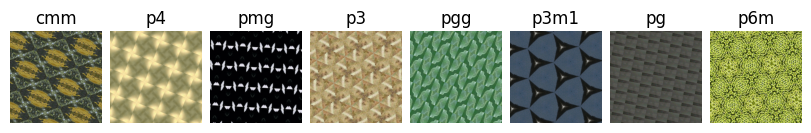

In [8]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

imagenet_ds = hdf5_dataset('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', folder='imagenet', transform=transforms.ToTensor())
imagenet_dl = DataLoader(imagenet_ds, batch_size=64, shuffle=False, num_workers=2)
viz_dataloader(imagenet_dl, label_converter=label_converter)

### generate embeddings

In [3]:
model = resnet50_(3, 17)
model.load_state_dict(torch.load('../../models/ResNet50/03132025-ResNet50-benchmark-10m/epoch_23.pth', map_location='cpu', weights_only=True))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc = nn.Identity()  # Remove the final classification layer to get embeddings
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', 'r') as h5:
    h5_group = h5['imagenet']
    data = h5_group['data']
    print(data.shape)
    
    with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0_ResNet50_embeddings.h5', 'w') as h5_out:
        h5_out.create_dataset('embeddings', shape=(data.shape[0], 2048), dtype='float32')
        for i in tqdm(range(data.shape[0])):
            img = data[i]
            img = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float() / 255.0
            with torch.no_grad():
                embedding = model(img)
            h5_out['embeddings'][i] = embedding.cpu().numpy()

(10013, 256, 256, 3)


100%|██████████| 10013/10013 [12:42<00:00, 13.13it/s]


In [ ]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0_ResNet50_embeddings.h5', 'r') as h5:
    viz_h5_structure(h5)
    
    print(h5['embeddings'][:5])

'Dataset': embeddings; Shape: (10013, 2048); dtype: float32
[[5.33669353e-01 9.00103629e-01 1.46383750e+00 ... 5.04102260e-02
  9.16822016e-01 6.74353912e-02]
 [5.37377633e-02 1.38878539e-01 3.91567022e-01 ... 7.00604200e-01
  4.99897897e-02 6.73411938e-04]
 [2.79406132e-03 6.05612025e-02 0.00000000e+00 ... 1.19032145e-01
  7.69485720e-04 2.72758901e-01]
 [2.89863944e-02 8.68181467e-01 2.25061458e-02 ... 6.84287727e-01
  1.10030994e-01 2.18566567e-01]
 [7.40307849e-03 1.21742189e+00 5.37331343e-01 ... 2.33994089e-02
  4.18225676e-02 0.00000000e+00]]


In [ ]:
model = xcit_small(3, 17)
model.load_state_dict(torch.load('../../models/XCiT/03132025-XCiT-benchmark-10m/epoch_24.pth', map_location='cpu', weights_only=True))

<All keys matched successfully>

In [ ]:
model.eval()

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (pos_embed): PositionalEncodingFourier(
    (token_projection): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x 

In [ ]:
model.head = nn.Identity()  # Remove the final classification layer to get embeddings
model.eval()

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (pos_embed): PositionalEncodingFourier(
    (token_projection): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x 

In [ ]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', 'r') as h5:
    h5_group = h5['imagenet']
    data = h5_group['data']
    print(data.shape)
    
    with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0_xcit_embeddings.h5', 'w') as h5_out:
        h5_out.create_dataset('embeddings', shape=(data.shape[0], 384), dtype='float32')
        for i in tqdm(range(data.shape[0])):
            img = data[i]
            img = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float() / 255.0
            with torch.no_grad():
                embedding = model(img)
            h5_out['embeddings'][i] = embedding.cpu().numpy()

(10013, 256, 256, 3)


100%|██████████| 10013/10013 [20:50<00:00,  8.01it/s]


In [ ]:
with h5py.File('../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0_xcit_embeddings.h5', 'r') as h5:
    viz_h5_structure(h5)
    
    print(h5['embeddings'][:5])

'Dataset': embeddings; Shape: (10013, 384); dtype: float32
[[ 8.0026867e-04  9.2046097e-04  3.5570911e-03 ... -4.0445660e-04
   1.8727551e-04  1.5299559e-03]
 [ 1.4723408e-03  1.0559600e-03  1.5489649e-04 ...  3.2264463e-04
   2.2407285e-05 -1.5636458e-03]
 [ 1.5780854e-03  1.0829333e-03  1.7200188e-03 ...  4.2441179e-04
   2.0487205e-05 -2.1541815e-03]
 [ 1.1525353e-03  9.7975903e-04  4.7592833e-04 ... -1.0869782e-04
   1.2807883e-04  6.3858570e-05]
 [ 5.0207018e-04  8.5420749e-04  1.9978317e-03 ... -7.6333422e-04
   2.6043880e-04  2.5814015e-03]]
